# Approximation of a time-dependent 3D bubble shape

## Outline

1. [Starting point](#starting_point)
2. [Parameterization](#parameterization)
3. [Training, validation, and test data](#data_splitting)
4. [Simple function approximation](#function_approximation)
5. [Model training](#model_training)
6. [Testing the model](#model_test)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>

- approximate r(phi, theta, t)
- moving reference frame data, include animation

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    import urllib
    import cloudpickle as cp
else:
    import pickle
    matplotlib.rcParams['figure.dpi'] = 80
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Sklearn version: {}".format(sk.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))
print("Executing PyTorch operations using {}.".format(device))

Pandas version: 0.24.2
Numpy version: 1.16.2
PyTorch version: 1.0.0
Sklearn version: 0.19.1
Running notebook locally.
Executing PyTorch operations using cuda.


In [2]:
if not IN_COLAB:
    data_file = "../data/3mm_l12_shape.pkl"
    with open(data_file, 'rb') as file:
        data = pickle.load(file)
else:
    data_file = "https://github.com/AndreWeiner/machine-learning-applied-to-cfd/blob/master/data/3mm_l12_shape.pkl?raw=true"
    response = urllib.request.urlopen(data_file)
    data = cp.load(response)

print("The data set contains {} points.".format(data.shape[0]))
data.sample(10)

The data set contains 1168729 points.


,x,y,z,t
454293,-0.234831,-0.055753,0.575933,2.048458
134075,-0.418379,0.149579,-0.263616,0.617505
967407,0.211943,-0.151385,0.508100,4.185022
386158,-0.058755,-0.126493,0.563604,1.740088
690597,-0.062256,0.242365,0.289625,3.061674
421871,-0.176102,-0.063379,-0.586204,1.938326
595277,-0.031017,0.194884,0.488800,2.665198
427160,-0.528955,-0.085049,0.292703,1.938326
500585,-0.088606,0.292549,0.145844,2.246696
844141,0.400196,-0.218748,0.107935,3.678414


## Parameterization<a id="parameterization"></a>

In [3]:
def spherical_coordinates(px, py, pz):
    '''Converts Cartesian coordinates x, y, z to spherical coordinates r, phi, theta.
    
    Parameters
    ----------
    px, py, pz - array-like: x, y, and z coordinates
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like   : polar angle
    theta - array-like : azimuth angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py) + np.square(pz))
    phi = np.where(px >= 0, np.arccos(py / radius), 2.0 * np.pi - np.arccos(py / radius))
    theta = (np.arctan2(px, pz) + np.pi) % np.pi
    return radius, phi, theta


def cartesian_coordinates(radius, phi, theta):
    '''Converts spherical coordinates r, phi, theta to Cartesian coordinates x, y, z.
    
    Parameters
    ----------
    radius, phi, theta - array-like: radius, polar angle, and azimuth angle
    
    Returns
    -------
    x, y, z - array-like : Cartesian coordinates
    
    '''
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.cos(phi)
    z = radius * np.sin(phi) * np.sin(theta)
    return x, y, z

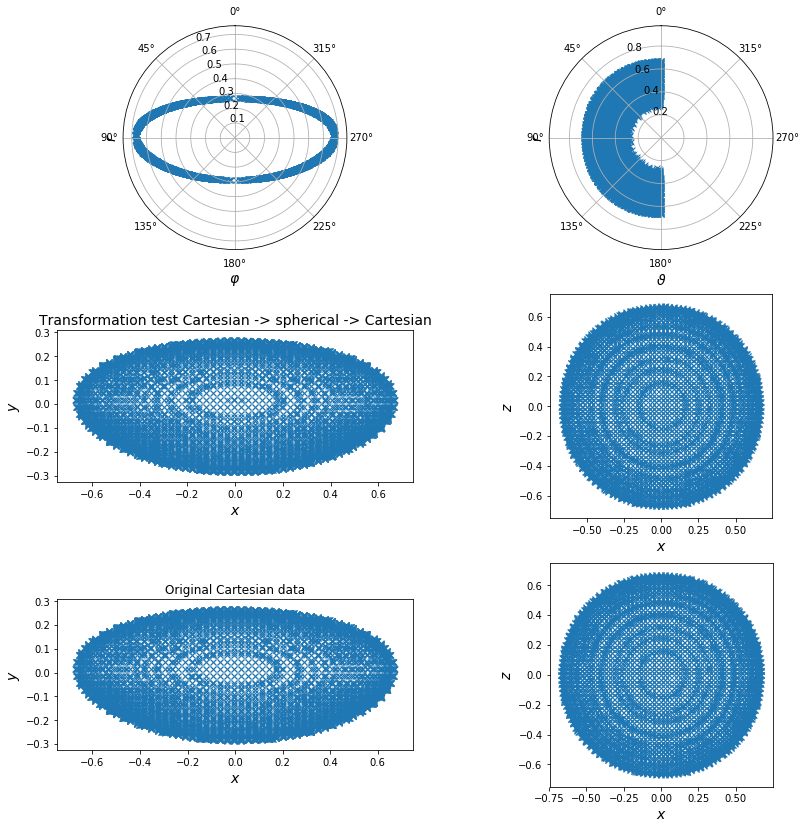

In [4]:
test_time = data.sample(1).t.values[0]
test_data = data[data.t == test_time]

%matplotlib inline
fontsize = 14

fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot(321, projection='polar')
ax2 = plt.subplot(322, projection='polar')
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)

rad, phi, theta = spherical_coordinates(test_data.x.values, test_data.y.values, test_data.z.values)
x, y, z = cartesian_coordinates(rad, phi, theta)

ax1.set_theta_zero_location("N")
ax1.scatter(phi, rad, marker='x', color='C0', s=30, linewidth=0.5)
ax1.set_xlim(0.0, 2.0*np.pi)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.set_theta_zero_location("N")
ax2.scatter(theta, rad, marker='x', color='C0', s=30, linewidth=0.5)
ax1.set_xlim(0.0, 2.0*np.pi)
ax2.set_xlabel(r"$\vartheta$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)

ax3.scatter(x, y, marker='x', color='C0', s=30, linewidth=0.5)
ax3.set_xlabel(r"$x$", fontsize=fontsize)
ax3.set_ylabel(r"$y$", fontsize=fontsize)
ax3.set_aspect('equal')
ax3.set_title(r"Transformation test Cartesian -> spherical -> Cartesian", fontsize=fontsize)

ax4.scatter(x, z, marker='x', color='C0', s=30, linewidth=0.5)
ax4.set_xlabel(r"$x$", fontsize=fontsize)
ax4.set_ylabel(r"$z$", fontsize=fontsize)
ax4.set_aspect('equal')

ax5.scatter(test_data.x.values, test_data.y.values, marker='x', color='C0', s=30, linewidth=0.5)
ax5.set_xlabel(r"$x$", fontsize=fontsize)
ax5.set_ylabel(r"$y$", fontsize=fontsize)
ax5.set_aspect('equal')
ax5.set_title(r"Original Cartesian data")

ax6.scatter(test_data.x.values, test_data.z.values, marker='x', color='C0', s=30, linewidth=0.5)
ax6.set_xlabel(r"$x$", fontsize=fontsize)
ax6.set_ylabel(r"$z$", fontsize=fontsize)
ax6.set_aspect('equal')
    
plt.show()

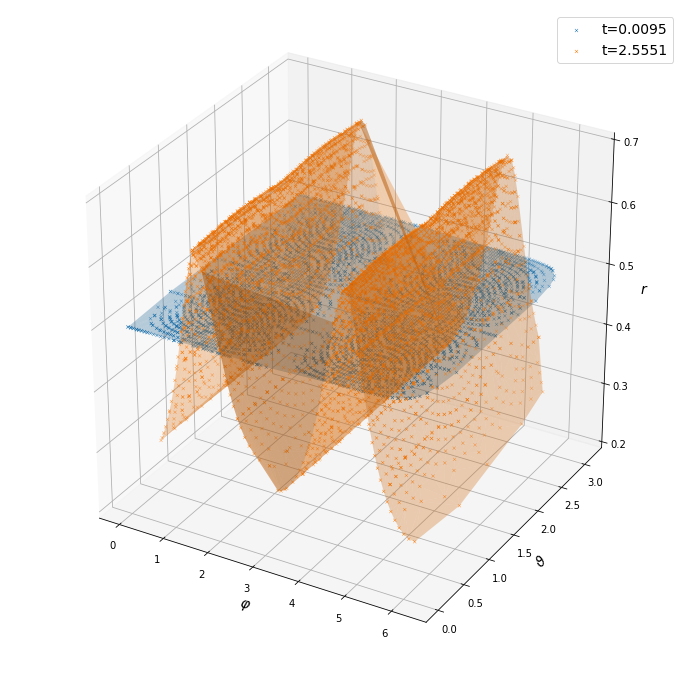

In [5]:
every_instance = 25
times = sorted(data['t'].unique())[::every_instance]

every = 4
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colors = ["C{:1d}".format(i) for i in range(len(times))]

for i, t in enumerate(times):
    data_temp = data[data.t == t]
    rad, phi, theta = spherical_coordinates(data_temp.x.values, data_temp.y.values, data_temp.z.values)
    ax.scatter(phi[::every], theta[::every], rad[::every],
               marker='x', color=colors[i], s=10, linewidth=0.5, label=r"t={:2.4f}".format(t))
    ax.plot_trisurf(phi[::every], theta[::every], rad[::every], color=colors[i], alpha=0.3)

ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$\vartheta$", fontsize=fontsize)
ax.set_zlabel(r"$r$", fontsize=fontsize)
ax.set_zlim(0.2, 0.7)
plt.legend(fontsize=fontsize)
plt.show()

## Training, validation, and test data<a id="data_splitting"></a>

In [6]:
rad, phi, theta = spherical_coordinates(data.x.values, data.y.values, data.z.values)
X = np.vstack([phi, theta, data.t.values]).T
X_train, X_tv, r_train, r_tv = train_test_split(X, rad, test_size=0.2, random_state=42)
X_val, X_test, r_val, r_test = train_test_split(X_tv, r_tv, test_size=0.5, random_state=42)

print("The training set contains {} points.".format(X_train.shape[0]))
print("The validation set contains {} points.".format(X_val.shape[0]))
print("The test set contains {} points.".format(X_test.shape[0]))

The training set contains 934983 points.
The validation set contains 116873 points.
The test set contains 116873 points.


## Simple function approximation<a id="function_approximation"></a>

In [22]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid, batch_norm=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.batch_norm = batch_norm
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        if self.batch_norm:
            self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons*2, bias=False))
            self.layers.append(torch.nn.BatchNorm1d(self.n_neurons*2))
            # add more hidden layers if specified
            if self.n_layers > 2:
                for hidden in range(self.n_layers-2):
                    self.layers.append(torch.nn.Linear(self.n_neurons*2, self.n_neurons*2, bias=False))
                    self.layers.append(torch.nn.BatchNorm1d(self.n_neurons*2))
            self.layers.append(torch.nn.Linear(self.n_neurons*2, self.n_neurons, bias=False))
            self.layers.append(torch.nn.BatchNorm1d(self.n_neurons))
        else:
            self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
            if self.n_layers > 1:
                for hidden in range(self.n_layers-1):
                    self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        print("Created model with {} weights.".format(self.model_parameters()))
        
    def forward(self, x):
        if self.batch_norm:
            for i_layer in range(len(self.layers)-1):
                if isinstance(self.layers[i_layer], torch.nn.Linear):
                    x = self.layers[i_layer](x)
                else:
                    x = self.activation(self.layers[i_layer](x))
        else:
            for i_layer in range(len(self.layers)-1):
                x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)
    
    def model_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [39]:
def approximate_function(x_train, y_train, x_val, y_val, model, l_rate=0.001, batch_size=128,
                         max_iter=1000, path=None, verbose=100):
    '''Train MLP to approximate a function y(x).
       The training stops when the maximum number of training epochs is reached.
    
    Parameters
    ----------
    x_train - array-like : argument of the function; used for training
    y_train - array-like : function value at x; used for training
    x_val - array-like   : argument of the function; used for validation
    y_val - array-like   : function value at x; used for validation
    model - SimpleMLP    : PyTorch model which is adjusted to approximate the function
    l_rate - Float       : learning rate for weight optimization
    batch_size - Integer : batch size for training data
    max_iter - Integer   : maximum number of allowed training epochs
    path - String        : location to save model weights
    verbose - Integer    : defines frequency for loss information output
    
    Returns
    -------
    model - SimpleMLP       : trained version of the given model
    loss_train - array-like : training loss
    loss_val - array-like   : validation loss
    
    '''
    # convert numpy arrays to torch tensors
    x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
    y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
    x_val_tensor = torch.from_numpy(x_val.astype(np.float32))
    y_val_tensor = torch.from_numpy(y_val.astype(np.float32))
    # define loss function
    criterion = torch.nn.MSELoss()
    # define optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)
    
    # training loop
    history_train = []
    history_val = []
    best_loss = 1.0E5
    count = 0
    # move model and data to gpu if available
    model.to(device)
    x_val_device, y_val_device = x_val_tensor.to(device), y_val_tensor.to(device)
    n_batches = np.ceil(x_train.shape[0] / batch_size)
    
    for e in range(1, max_iter+1):
        # backpropagation
        model = model.train()
        loss_sum_batches = 0.0
        for b in range(int(n_batches)):
            x_batch = x_train_tensor[b*batch_size:min(x_train_tensor.shape[0], (b+1)*batch_size)].to(device)
            y_batch = y_train_tensor[b*batch_size:min(x_train_tensor.shape[0], (b+1)*batch_size)].to(device)
            optimizer.zero_grad()
            output_train = model(x_batch)
            loss_train = criterion(output_train.squeeze(dim=1), y_batch)
            loss_train.backward()
            optimizer.step()
            loss_sum_batches += loss_train.item()
        history_train.append(loss_sum_batches / n_batches)
        
        # validation
        with torch.no_grad():
            model = model.eval()
            output_val = model.forward(x_val_device)
            loss_val = criterion(output_val.squeeze(dim=1), y_val_device)
            history_val.append(loss_val.item())
            
        # check maximum error for validation data
        diff_val = output_val.squeeze(dim=1) - y_val_device
        max_diff_val = np.amax(np.absolute(diff_val.cpu().detach().numpy()))
        if history_train[-1] < best_loss:
            count += 1
            best_loss = history_train[-1]
            if count % verbose == 0:
                print("Training loss decreased in epoch {}: {}".format(e, history_train[-1]))
                print("Validation loss/max. dev.: {}/{}".format(loss_val.item(), max_diff_val))
                print("--------------------------------")
            if path is not None:
                if count % verbose == 0: print("Saving model as {}".format(path))
                torch.save(model.state_dict(), path)
    return model.eval(), np.asarray(history_train), np.asarray(history_val)

In [9]:
def set_path(name=None):
    if IN_COLAB:
        return F"/content/gdrive/My Drive/" + name
    else:
        return "models/" + name

## Model training<a id="model_training"></a>

In [38]:
n_layers = range(1, 11)
n_neurons = range(10, 80, 10)
min_loss = 100

for i in range(1000):
    print("Iteration {}\n------------".format(i))
    layers = np.random.choice(n_layers, 1)[0]
    neurons = np.random.choice(n_neurons, 1)[0]
    radius_model = SimpleMLP(n_inputs=3, n_outputs=1, n_layers=layers, n_neurons=neurons, activation=torch.relu, batch_norm=False)
    radius_model, train_loss, val_loss = approximate_function(X_train, r_train, X_val, r_val, radius_model, max_iter=1000,
                                            l_rate=0.001, batch_size=100000, path=set_path("3mm_radius_model.pt"), verbose=1000)
    if np.amin(val_loss) < min_loss:
        print("\033[1mValidation loss decreased to {:2.4e}\033[0m. Saving model.".format(min_loss))
        min_loss = np.amin(val_loss)
        torch.save(radius_model.state_dict(), set_path("3mm_radius_model_best.pt"))
        best_layers = layers
        best_neurons = neurons
    print("")

Iteration 0
------------
Created model with 161 weights.
Number of batches: 10.0
Validation loss decreased to 1.0000e+02. Saving model.

Iteration 1
------------
Created model with 821 weights.
Number of batches: 10.0
Validation loss decreased to 1.2322e-01. Saving model.

Iteration 2
------------
Created model with 8521 weights.
Number of batches: 10.0
Validation loss decreased to 8.6892e-03. Saving model.

Iteration 3
------------
Created model with 931 weights.
Number of batches: 10.0

Iteration 4
------------
Created model with 8401 weights.
Number of batches: 10.0



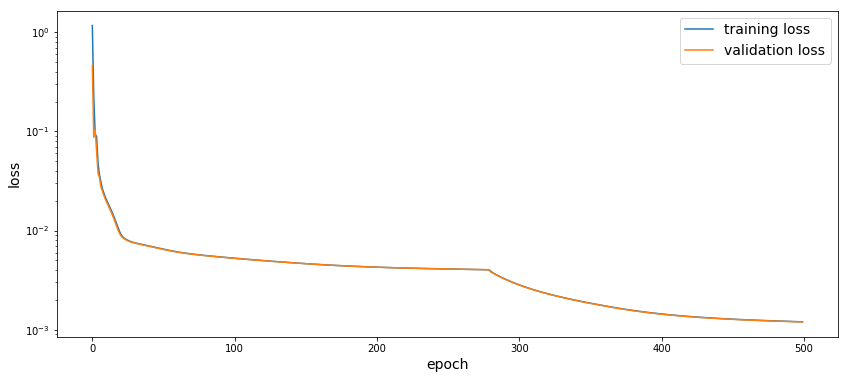

In [32]:
plt.figure(figsize=(14,6))
plt.semilogy(range(len(train_loss)), train_loss, label=r"training loss")
plt.semilogy(range(len(val_loss)),  val_loss, label=r"validation loss")
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

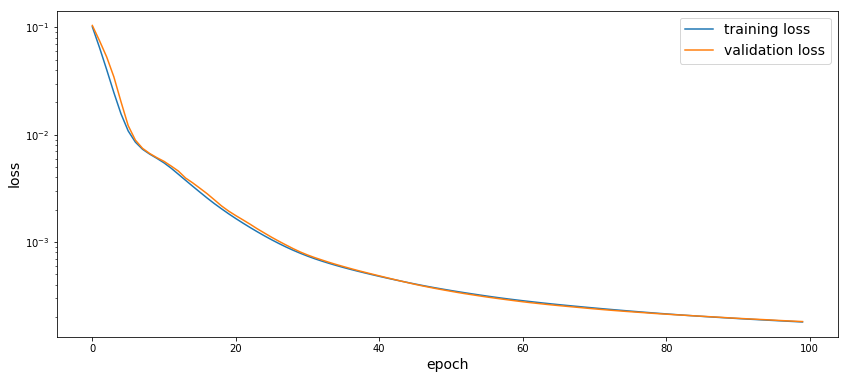

In [28]:
plt.figure(figsize=(14,6))
plt.semilogy(range(len(train_loss)), train_loss, label=r"training loss")
plt.semilogy(range(len(val_loss)),  val_loss, label=r"validation loss")
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

## Testing the model<a id="model_test"></a>

would be better to use data from intermediate time steps

## Final notes<a id="final_notes"></a>